In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt


In [20]:
train = pd.read_csv("data/train.csv", index_col='ID')
train.fillna(0, inplace=True)
wv = train.pop('wind_speed')
wd_rad = train.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
train['Wx'] = wv*np.cos(wd_rad)
train['Wy'] = wv*np.sin(wd_rad)

date_time = pd.to_datetime(train.pop('measurement_time'), format='%Y-%m-%d %H:%M:%S')
date_time_utc = date_time.dt.tz_localize('Europe/Paris', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

train['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
train.head()

,target,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,clouds,Wx,Wy,Day sin,Day cos,Year sin,Year cos
ID,,,,,,,,,,,,,,,,,,,
0,3.400000,27.600000,18.799999,19.750000,21.100000,20.129892,0.0,0.0,0.0,0.0,0.0,8.97,20.0,-1.578052,1.324142,3.427392e-13,1.000000,-0.867922,0.496700
1,2.933333,28.400000,18.933333,19.833333,21.033333,20.052919,0.0,0.0,0.0,0.0,0.0,9.19,100.0,-0.704561,1.935767,2.588190e-01,0.965926,-0.867566,0.497322
2,7.166667,29.400000,19.000000,19.799999,21.000000,19.992375,0.0,0.0,0.0,0.0,0.0,9.42,20.0,-1.968734,1.651964,5.000000e-01,0.866025,-0.867209,0.497944
3,10.500000,30.100000,19.033333,19.933333,24.600000,19.941565,0.0,0.0,0.0,0.0,0.0,9.19,100.0,-2.225685,1.285000,7.071068e-01,0.707107,-0.866852,0.498565
4,8.733334,31.866666,19.100000,20.000000,24.700000,19.924502,0.0,0.0,0.0,0.0,0.0,9.99,100.0,-2.415010,0.878992,8.660254e-01,0.500000,-0.866495,0.499187


In [3]:
train[train.isna().any(axis=1)]

,target,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,clouds,Wx,Wy,Day sin,Day cos,Year sin,Year cos
ID,,,,,,,,,,,,,,,,,,,


In [158]:
#scaler_all = MinMaxScaler(feature_range=(0, 1))
#train_scaled = scaler_all.fit_transform(train)
#y = train_scaled[:, 0].reshape(-1, 1)
#X = train_scaled[:, 1:]
#print(X.shape, y.shape)

In [43]:
data = train.drop(columns=['target']).values
target = train['target'].values

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(data)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(target.reshape(-1, 1))
print(X.shape, y.shape)
#print(data.shape, target.shape)


(7047, 18) (7047, 1)


Epoch 1/10


c:\Users\trist_243cr5c\Desktop\projects\demand_comp\Demand_Forecasting_Comp\.env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.1436 - val_loss: 0.1023
Epoch 2/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.1132 - val_loss: 0.0503
Epoch 3/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1105 - val_loss: 0.0522
Epoch 4/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1022 - val_loss: 0.0578
Epoch 5/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0994 - val_loss: 0.0821
Epoch 6/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0982 - val_loss: 0.0532
Epoch 7/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0935 - val_loss: 0.0644
Epoch 8/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0895 - val_loss: 0.0476
Epoch 9/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0897 - val_loss: 0.0526
Epoch 10/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0864 - val_loss: 0.0470
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train Score: 12.106873321714884 MAE
Test Score: 8.0690020

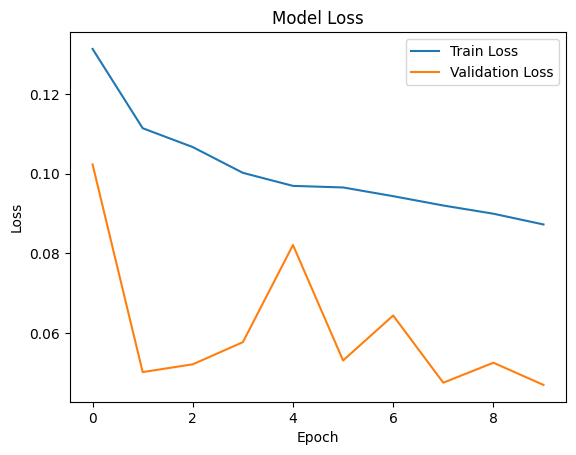

In [44]:
time_step = 24
# Reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into train and test sets
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Define the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (time_step, 1)))     
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=12, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)

# Calculate MAE
train_score = mean_absolute_error(y_train, train_predict)
test_score = mean_absolute_error(y_test, test_predict)
print(f'Train Score: {train_score} MAE')
print(f'Test Score: {test_score} MAE')
# Plot the loss during training

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [45]:
test = pd.read_csv("data/test.csv", index_col='ID')
test.fillna(method='ffill', inplace=True)
wv = test.pop('wind_speed')
wd_rad = test.pop('wind_direction')*np.pi / 180
test['Wx'] = wv*np.cos(wd_rad)
test['Wy'] = wv*np.sin(wd_rad)
date_time = pd.to_datetime(test.pop('measurement_time'), format='%Y-%m-%d %H:%M:%S')
date_time_utc = date_time.dt.tz_localize('Europe/Paris', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day
test['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
test['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
test['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
test['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


C:\Users\trist_243cr5c\AppData\Local\Temp\ipykernel_8284\3163477029.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


In [46]:
test_scaled = scaler.transform(test)
test_scaled = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[1], 1)

test_predict = model.predict(test_scaled)
test_predict = scaler_y.inverse_transform(test_predict)

18/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

c:\Users\trist_243cr5c\Desktop\projects\demand_comp\Demand_Forecasting_Comp\.env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [47]:
sample_submission = pd.read_csv("data/sample_submission.csv", index_col="ID")
test_submission = sample_submission.copy()
test_submission["target"] = test_predict

test_submission.to_csv("submissions/lstm/submission26.csv")